In [148]:
import numpy as np
import pandas as pd

from scipy.integrate import odeint
import matplotlib.pyplot as plt
import matplotlib

import matplotlib.dates as mdates
import datetime as dt

from datetime import date


1. Importing the data

In [149]:
cov = pd.read_csv('corona2.csv')

In [150]:
cov.head()

,%,Dia,Casos,Recuperados,Obitos
0,NaN,2.0,2,0,0
1,100.000000,3.0,4,0,0
2,50.000000,4.0,6,0,0
3,50.000000,5.0,9,0,0
4,44.444444,6.0,13,0,0


In [151]:
casos_cum = np.array(cov['Casos'])[0:92]
obitos = np.array(cov['Obitos'])[0:92]
recuperados = np.array(cov['Recuperados'])[0:92]
ativos = np.array(casos_cum - obitos - recuperados)


In [152]:
ativos

array([    2,     4,     6,     9,    13,    21,    30,    39,    41,
          59,    78,   112,   168,   243,   328,   444,   637,   779,
        1009,  1263,  1581,  2023,  2307,  2930,  3451,  4149,  5027,
        5800,  6225,  7240,  8021,  8757,  9572, 10183, 10908, 11279,
       11913, 12565, 13342, 14804, 15251, 15804, 16122, 16534, 17109,
       17719, 17846, 18388, 18882, 19518, 19700, 20054, 20332, 20715,
       21114, 21451, 21561, 21804, 21881, 22184, 22333, 22496, 22550,
       22749, 22885, 23017, 23352, 23732, 23781, 23897, 23986, 23737,
       23775, 23937, 24065, 23785, 23182, 21548, 21754, 21945, 22183,
       21321, 21464, 11758, 11636, 11569, 11587, 11590, 11652, 11621,
       11681, 11724])

In [153]:
casos_novos=[2]

for i in range(len(casos_cum)-1):
    casos_novos.append(casos_cum[i+1]-casos_cum[i])
    
casos_novos=np.array(casos_novos)    

In [154]:
casos_novos

array([   2,    2,    2,    3,    4,    8,    9,    9,    2,   18,   19,
         34,   57,   76,   86,  117,  194,  143,  235,  260,  320,  460,
        302,  633,  559,  714,  902,  792,  446, 1035,  808,  783,  852,
        638,  754,  452,  712,  699,  815, 1516,  515,  598,  349,  514,
        643,  750,  181,  663,  521,  657,  516,  603,  371,  444,  474,
        412,  163,  295,  183,  368,  295,  203,   92,  242,  178,  480,
        533,  553,  138,  175,   98,  234,  219,  187,  264,  227,  226,
        173,  223,  228,  252,  288,  271,  152,  165,  219,  285,  304,
        350,  257,  297,  200])

2. Moving average trend for the new daily cases

In [155]:
from math import floor

def cma(L, n):

    f = floor(n/2)
    l = len(L)
    
    n_cma = []
    
    for i in range(f):
        n_cma.append(np.mean(L[0 : 2*i+1]))
    
    for i in range(l-2*f):
        n_cma.append(np.mean(L[i : i+2*f+1]))
        
    for i in range(f):
        n_cma.append(np.mean(L[l-2*(f-1-i)-1 : l]))
        
        
    return n_cma    

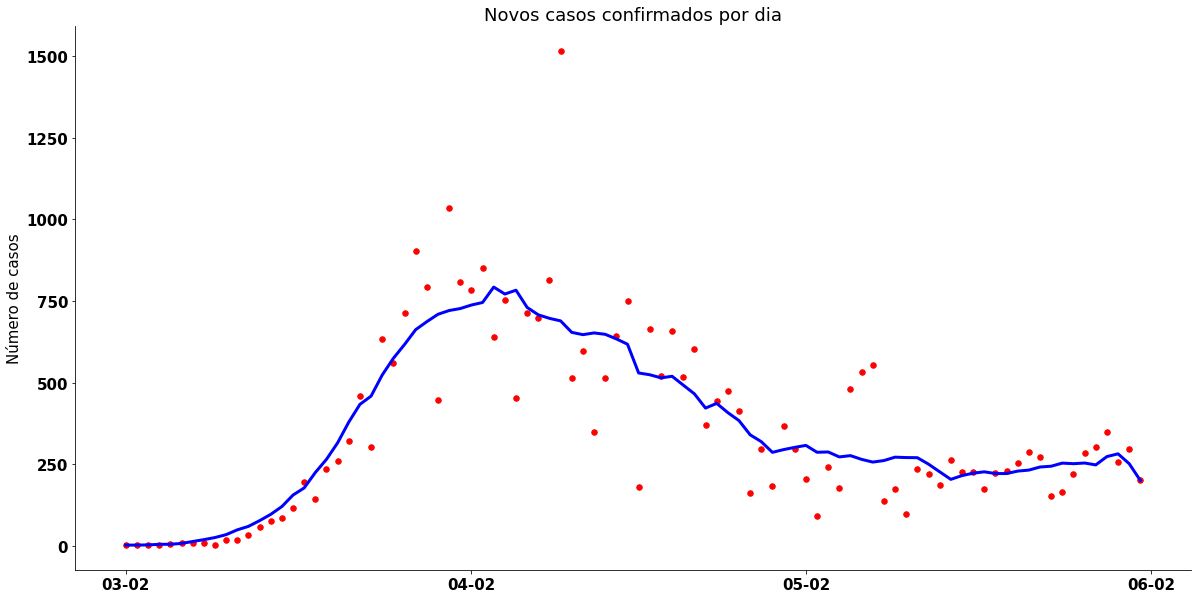

In [156]:

l= len(casos_novos)

aver = cma(casos_novos, 13)

fig = plt.figure(figsize=(20,10))
ax = fig.gca()

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

march_2 = dt.date(2020,3,2)
then = march_2 + dt.timedelta(days=260)
t = mdates.drange(march_2,then,dt.timedelta(days=1))
t = t.astype('int32')

ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
ax.xaxis.set_major_locator(mdates.DayLocator([2]))


plt.plot(t[0:92], aver,'b', linewidth=3.0)
plt.scatter(t[0:92], casos_novos, s=30, color='red', marker='o')


plt.ylabel('Número de casos')
plt.yticks([0, 250, 500, 750, 1000, 1250, 1500])


plt.title('Novos casos confirmados por dia')

plt.show()

In [157]:
len(aver)

92

In [158]:
len(casos_novos)

92

In [159]:
aver[-1]

200.0

3. The model differential equations

In [160]:
# function with the model equations

def deriv(X, t):
    S, E, I_m, I_s, I_d, R_m, R_s, D = X 
    
    
    
    lam = beta*(sigma*I_m + I_s)/(N-I_d)
    
    
    
    dS = -S*lam
    dE = S*lam - alpha*E
    dI_m = p*alpha*E - gamma_m*I_m
    dI_s = (1-p)*alpha*E - mu*I_s
    dI_d = mu*I_s - gamma_s*I_d - eta*I_d
    
    dR_m = gamma_m*I_m
    dR_s = gamma_s*I_d
    dD = eta*I_d
    
    
    return [dS, dE, dI_m, dI_s, dI_d, dR_m, dR_s, dD]

In [161]:
# Initial conditions for the parameters

alpha = 1/4
mu = 1/5

gamma_m = 1/7
gamma_s = 1/14
sigma = 0.5
p = 0.8
eta = 0.0032  #0.000940802# 0.00142#


m = pow(10,6)
N = 10.2*m
c = 13.74


In [162]:
# Estimation of best parameters R_0 and I using least squares method 
    
    
I_m = 9.6
I_s = 2.4
I_d = 2
E = 13.74*12
R_m = 0
R_s = 0
D = 0
S = 10.2*m - I_m - I_s - I_d - E - R_m - R_s - D
    
r_0 = 3


    
epsi = r_0/(c*(p*sigma/gamma_m + (1-p)/(mu)))
    
beta = c*epsi
   
    
    
X = S, E, I_m, I_s, I_d, R_m, R_s, D
       
    
diag_prev = odeint(deriv, X, np.linspace(1,17, 17))
diag_prev = np.around(diag_prev)
   
cum1 = diag_prev[:,4]+diag_prev[:,6]+diag_prev[:,7]
            
     
d_0 = sum((cum1[:] - aver[0:17])**2)
                                                 




for r_0 in np.linspace(3,7, 81):
                
        
        epsi = r_0/(c*(p*sigma/gamma_m + (1-p)/mu))

        beta = c*epsi
    
        for I in np.linspace(5, 40, 36):

    
            I_m = 0.8*I
            I_s = 0.2*I
            E = 13.74*I

            X = S, E, I_m, I_s, I_d, R_m, R_s, D
    
    
            diag_prev = odeint(deriv, X, np.linspace(1,17,17))
            diag_prev = np.around(diag_prev)
            
            cum1 = diag_prev[:,4]+diag_prev[:,6]+diag_prev[:,7]
            
            cum1 = np.append([0], cum1)
    
            dist = sum((cum1[1:]-cum1[:-1]- aver[0:17])**2)
            if dist < d_0:
                d_0 = dist
                param = r_0, I
                c1 = cum1
      
    
print(param) 

(4.85, 30.0)


In [163]:
c1

array([  0.,   2.,   5.,  11.,  19.,  30.,  44.,  62.,  85., 113., 149.,
       194., 251., 324., 415., 530., 678., 861.])

In [164]:
aver[0:17]

[2.0,
 2.0,
 2.6,
 4.285714285714286,
 4.555555555555555,
 7.090909090909091,
 13.0,
 18.692307692307693,
 25.153846153846153,
 34.0,
 48.69230769230769,
 59.38461538461539,
 76.84615384615384,
 96.15384615384616,
 120.07692307692308,
 155.30769230769232,
 177.15384615384616]

In [165]:
I_m = 14.4
I_s = 3.6
I_d = 2
E = 13.74*12
R_m = 0
R_s = 0
D = 0
S = 10.2*m - I_m - I_s - I_d - E - R_m - R_s - D
    
r_0 = 6.25


    
epsi = r_0/(c*(p*sigma/gamma_m + (1-p)/(mu)))
    
beta = c*epsi
   
        
X = S, E, I_m, I_s, I_d, R_m, R_s, D
       
    
diag_prev = odeint(deriv, X, np.linspace(1,17, 17))
diag_prev = np.around(diag_prev)
   
    
cum1 = diag_prev[:,4]+diag_prev[:,6]+diag_prev[:,7]
cum1 = np.append([0], cum1)

print(cum1[1:]-cum1[:-1])

[  2.   1.   3.   4.   5.   7.  10.  12.  17.  24.  30.  41.  56.  73.
  99. 133. 178.]


In [166]:
# Estimation of parameter for second stange (19 march - 27 march) using least squares method 
    
    
I_m = 28
I_s = 7
I_d = 2
E = 13.74*35
R_m = 0
R_s = 0
D = 0
S = 10.2*m - I_m - I_s - I_d - E - R_m - R_s - D
    
r_0 = 4.75
c = 13.74

    
epsi = r_0/(c*(p*sigma/gamma_m + (1-p)/(mu)))
  
beta = c*epsi
    
    
    
X = S, E, I_m, I_s, I_d, R_m, R_s, D
       
    
phas1 = odeint(deriv, X, np.linspace(1, 17, 17))
phas1 = np.around(phas1)   


X = phas1[-1]    
    
d = 10


for r in np.linspace(0.1,1,201):

        
    beta = r*c*epsi


    phas2 = odeint(deriv, X, np.linspace(1,11,11))
    phas2 = np.around(phas2)
    
    cum2 = phas2[:,4]+phas2[:,6]+phas2[:,7]
        

    dist = sum((np.log(cum2[1:]-cum2[:-1]) - np.log(aver[17:27]))**2)

    if dist<d:
        d = dist
        red1 = r
        c2 = cum2
        
print(red1) 

0.4870000000000001


In [167]:
cum2

array([ 958., 1213., 1533., 1936., 2444., 3083., 3886., 4895., 6164.,
       7757., 9758.])

In [168]:
(7/13.64)*13.74

7.051319648093841

In [169]:
# Estimation of reduction on contact rate for third stange (28 march - 6 April ) using least squares method 


I_m = 28
I_s = 7
I_d = 2
E = 13.74*35
R_m = 0
R_s = 0
D = 0
S = 10.2*m - I_m - I_s - I_d - E - R_m - R_s - D
    
r_0 = 4.75
c = 13.74


    
epsi = r_0/(c*(p*sigma/gamma_m + (1-p)/(mu)))
  
beta = c*epsi
   
    
    
X = S, E, I_m, I_s, I_d, R_m, R_s, D
       
       
phas1 = odeint(deriv, X, np.linspace(1,17, 17))
phas1 = np.around(phas1)   

X = phas1[-1]    


beta = red1*c*epsi

phas2 = odeint(deriv, X, np.linspace(1,11,11))
phas2 = np.around(phas2)

X = phas2[-1]


d = 10


for r in np.linspace(0,1,201):

    
    beta = r*c*epsi


    phas3 = odeint(deriv, X, np.linspace(1,11,11))
    phas3 = np.around(phas3)
    
    cum3 = phas3[:,4]+phas3[:,6]+phas3[:,7]
        


    dist = sum((np.log(cum3[1:]-cum3[:-1]) - np.log(aver[27:37]))**2)

    if dist<d:
        d = dist
        red2 = r
        c3 = cum3
        
print(red2) 

0.17


In [170]:
cum3

array([ 5460.,  6227.,  7138.,  8263.,  9673., 11442., 13667., 16463.,
       19970., 24363., 29856.])

In [171]:
red2*r_0

0.8075000000000001

In [172]:
# Estimation of reduction on contact rate for third stange  using least squares method 


I_m = 28
I_s = 7
I_d = 2
E = 13.74*35
R_m = 0
R_s = 0
D = 0
S = 10.2*m - I_m - I_s - I_d - E - R_m - R_s - D
    
r_0 = 4.75
c = 13.74


    
epsi = r_0/(c*(p*sigma/gamma_m + (1-p)/(mu)))
  
beta = c*epsi
   
    
    
X = S, E, I_m, I_s, I_d, R_m, R_s, D
       
       
phas1 = odeint(deriv, X, np.linspace(1,17, 17))
phas1 = np.around(phas1)   

X = phas1[-1]    


beta = red1*c*epsi

phas2 = odeint(deriv, X, np.linspace(1,11,11))
phas2 = np.around(phas2)

X = phas2[-1]

beta = red2*c*epsi

phas3 = odeint(deriv, X, np.linspace(1,11,11))
phas3 = np.around(phas3)

X = phas3[-1]



d = 10


for r in np.linspace(0,1,201):

    
    beta = r*c*epsi


    phas4 = odeint(deriv, X, np.linspace(1,21,21))
    phas4 = np.around(phas4)
    
    cum4 = phas4[:,4]+phas4[:,6]+phas4[:,7]
        


    dist = sum((np.log(cum4[1:]-cum4[:-1]) - np.log(aver[37:57]))**2)

    if dist<d:
        d = dist
        red3 = r
        c3 = cum3
        
print(red3) 

0.155


In [173]:

    
I_m = 28
I_s = 7
I_d = 2
E = 13.74*35
R_m = 0
R_s = 0
D = 0
S = 10.2*m - I_m - I_s - I_d - E - R_m - R_s - D
    
r_0 = 4.75
c = 13.74

    
epsi = r_0/(c*(p*sigma/gamma_m+(1-p)/(mu)))
  
beta = c*epsi



X = S, E, I_m, I_s, I_d, R_m, R_s, D


phas1 = odeint(deriv, X, np.linspace(1,17, 17))
phas1 = np.around(phas1)   

X = phas1[-1]    


beta = red1*c*epsi

phas2 = odeint(deriv, X, np.linspace(1,11,11))
phas2 = np.around(phas2)

X = phas2[-1]


beta = red2*c*epsi

phas3 = odeint(deriv, X, np.linspace(1,11,11))
phas3 = np.around(phas3)

X = phas3[-1]

beta = red3*c*epsi

phas4 = odeint(deriv, X, np.linspace(1,21,21))
phas4 = np.around(phas4)


X = phas4[-1]

d = 10**10

red4=1

for r in np.linspace(0,1,201):

        
    beta = r*c*epsi


    phas5 = odeint(deriv, X, np.linspace(1,36,36))
    phas5 = np.around(phas5)
    
    cum5 = phas5[:,4]+phas5[:,6]+phas5[:,7]
    #print(np.log(cum4[1:]-cum4[:-1]))  
    #print(np.log(aver[57:80]))

    dist = sum((np.log(cum5[1:]-cum5[:-1]) - np.log(aver[57:92]))**2)
    #print(dist)
    
    if dist<d:
        d = dist
        red4 = r
        
print(red4) 

0.17


0.12257718532138208 1.6842105263157898


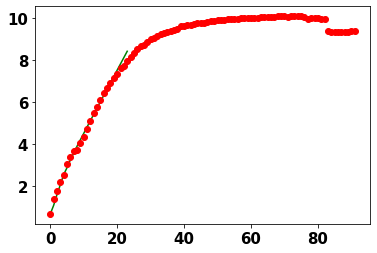

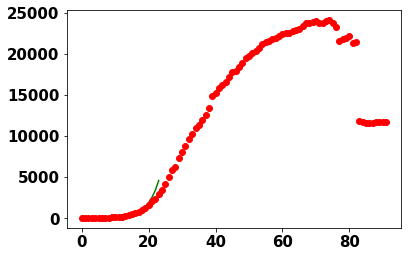

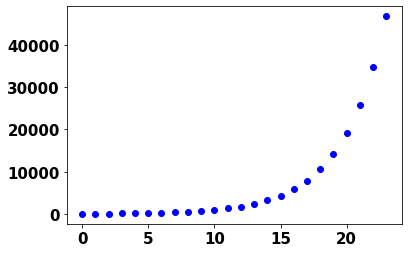

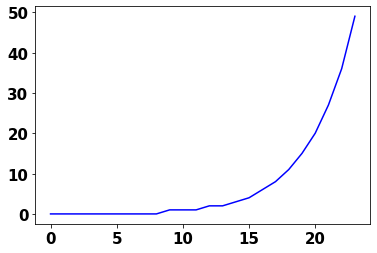

In [174]:
# Caso sem qualquer medida de mitigação

  
I_m = 9
I_s = 3
I_d = 2
E = 13.74*(I_m + I_s)
R_m = 0
R_s = 0
D = 0
S = 10.2*m - I_m - I_s - I_d - E - R_m - R_s - D




# Constantes de fase

r_0 = 6.4


epsi = r_0/(c*(p*sigma/gamma_m + (1-p)/mu))

beta = c*epsi

print(epsi, beta)



# Solução do sistema de equações diferenciais

X = S, E, I_m, I_s, I_d, R_m, R_s, D


phas1_por = odeint(deriv, X, np.linspace(1, 24, 24))
phas1_por = np.around(phas1_por)


plt.plot(np.log(phas1_por[:,4]),'g', np.log(ativos), 'ro')
plt.show()


plt.plot(phas1_por[:,4],'g', ativos, 'ro')
plt.show()


plt.plot(phas1_por[:,2]+phas1_por[:,3], 'bo')
plt.show()


plt.plot(phas1_por[:,7],'b')
plt.show()

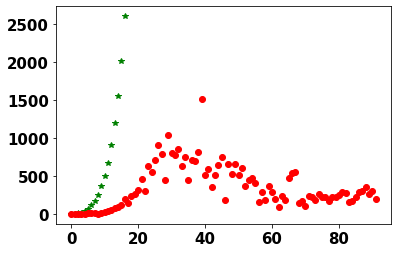

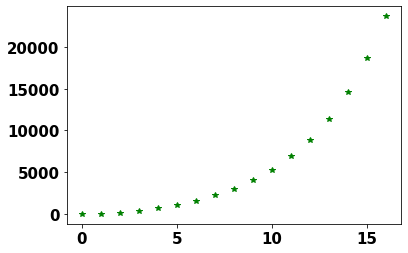

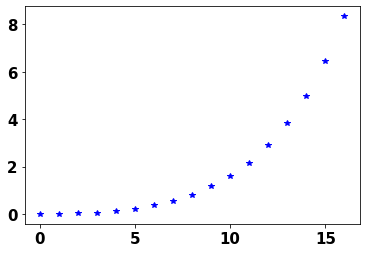

In [175]:
diagnosed = phas1[:,4]
cum = []

for i in range(len(diagnosed)): 
    cum.append(sum(diagnosed[0:i]))
    
    
real = phas1[:,2] + phas1[:,3]    
    
cum_real = []    
for i in range(len(diagnosed)): 
    cum_real.append(sum(real[0:i]))    


dead = eta * diagnosed
cum_dead = []
for i in range(len(diagnosed)): 
    cum_dead.append(sum(dead[0:i])) 



    
plt.plot(cum,'g*', casos_novos, 'ro')
plt.show()

plt.plot(cum_real,'g*')
plt.show()

plt.plot(cum_dead,'b*')
plt.show()

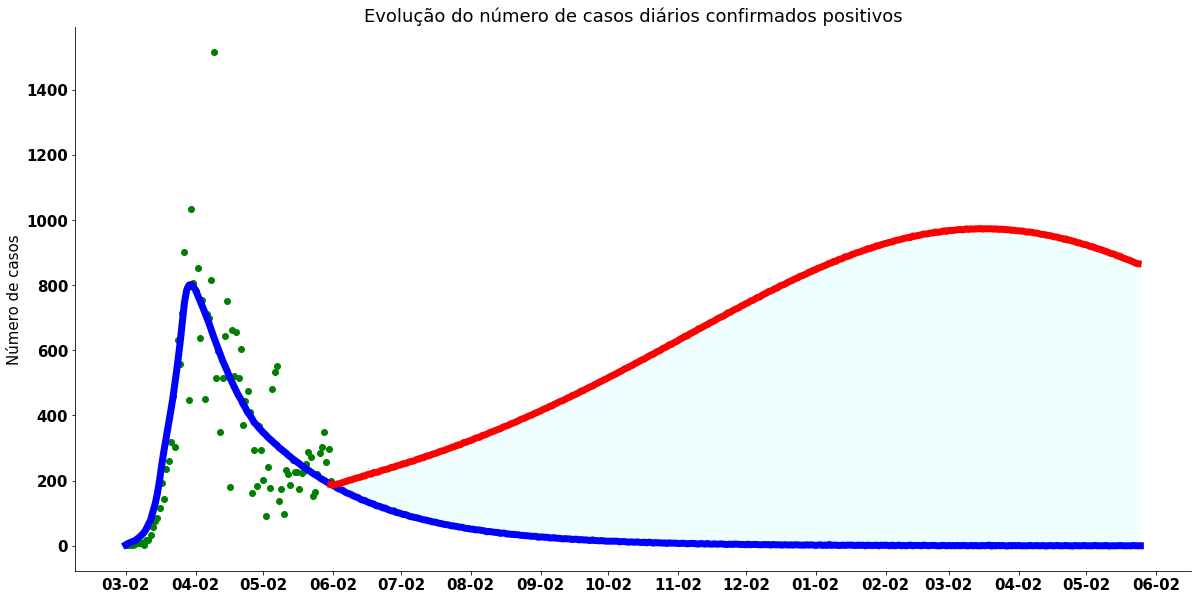

In [177]:
# Caso com medida de mitigação


I_m = 28
I_s = 7
I_d = 2
E = 13.74*(I_m + I_s)
R_m = 0
R_s = 0
D = 0
S = 10.2*m - I_m - I_s - I_d - E - R_m - R_s - D  




# Fase 1


r_0 = 4.75

c = 13.74

epsi = r_0/(c*(p*sigma/gamma_m + (1-p)/mu))

beta = c*epsi


X = S, E, I_m, I_s, I_d, R_m, R_s, D


phas1 = odeint(deriv, X, np.linspace(1,17,17))
phas1 = np.around(phas1)


cum_1 = phas1[:,4]+phas1[:,6]+phas1[:,7]




# Fase 2


beta = red1*c*epsi


X = phas1[-1]


phas2 = odeint(deriv, X, np.linspace(1,11, 11))
phas2 = np.around(phas2)


cum_2 = phas2[1:,4]+phas2[1:,6]+phas2[1:,7]

#caso2_novos = np.concatenate((phas1[:,4], phas2[1:,4]))


#plt.plot(caso2_novos,'g', ativos, 'ro')
#plt.show()




# Fase 3


beta = red2*c*epsi


X = phas2[-1]


phas3 = odeint(deriv, X, np.linspace(1,11, 11))
phas3 = np.around(phas3)

cum_3 = phas3[1:,4]+phas3[1:,6]+phas3[1:,7]




# Fase 4


beta = red3*c*epsi


X = phas3[-1]


phas4 = odeint(deriv, X, np.linspace(1,21,21))
phas4 = np.around(phas4)

cum_4 = phas4[1:,4]+phas4[1:,6]+phas4[1:,7]



# Fase 5


beta = red4*c*epsi


X = phas4[-1]


phas5 = odeint(deriv, X, np.linspace(1,36, 36))
phas5 = np.around(phas5)

cum_5 = phas5[1:,4]+phas5[1:,6]+phas5[1:,7]



# Fase 6a


beta = red4*c*epsi


X = phas5[-1]


phas6a = odeint(deriv, X, np.linspace(1,361, 361))
phas6a = np.around(phas6a)

cum_6a = phas6a[1:,4]+phas6a[1:,6]+phas6a[1:,7]




# Fase 6b


beta = 0.235*c*epsi


X = phas5[-1]


phas6b = odeint(deriv, X, np.linspace(1,361, 361))
phas6b = np.around(phas6b)


cum_6b = phas6b[1:,4]+phas6b[1:,6]+phas6b[1:,7]




cum = np.concatenate((cum_1, cum_2, cum_3, cum_4, cum_5, cum_6a))


novos_casos = cum[1:] - cum[:-1]


novos_casos_max = cum_6b[1:] - cum_6b[:-1]







fig = plt.figure(figsize=(20,10))
ax = fig.gca()


ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)


march_2 = dt.date(2020,3,2)
then = march_2 + dt.timedelta(days=271+180)
t = mdates.drange(march_2,then,dt.timedelta(days=1))
t = t.astype('int32')

ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
ax.xaxis.set_major_locator(mdates.DayLocator([2]))


dates = [date.fromordinal(t[0]), date.fromordinal(t[63]),   date.fromordinal(t[91]), date.fromordinal(t[192])]





plt.plot(t, novos_casos, color='blue', linewidth=7)

plt.plot(t[91:270+180], novos_casos_max, color='red', linewidth=7)

plt.fill_between(t[91:270+180], novos_casos[91:270+180], novos_casos_max, color='lightcyan', alpha=0.5)


plt.scatter(t[0:92], casos_novos[0:92], color='green', marker='o')





font = {'family' : 'DejaVu Sans',
        'weight' : 'bold',
        'size'   : 15}

matplotlib.rc('font', **font)


#plt.xticks(dates)

plt.ylabel('Número de casos')


plt.title('Evolução do número de casos diários confirmados positivos')


plt.show()


#plt.scatter(t[0:92], aver, color='gray', marker = 'o')



In [178]:
max(novos_casos_max)

974.0

In [179]:
0.235*6.25

1.46875

In [184]:
casos_cum = np.concatenate((phas1[:,4]+phas1[:,6]+phas1[:,7], phas2[1:,4]+phas2[1:,6]+phas2[1:,7], phas3[1:,4]+phas3[1:,6]+phas3[1:,7], phas4[1:,4]+phas4[1:,6]+phas4[1:,7], phas5a[1:,4]+phas5a[1:,6]+phas5a[1:,7]))
casos_novos_diarios = casos_cum[1:] - casos_cum[:-1]


phas5b_novos = phas5b[2:,4]+phas5b[2:,6]+phas5b[2:,7]-phas5b[1:-1,4]-phas5b[1:-1,6]-phas5b[1:-1,7]

NameError: name 'phas5a' is not defined

In [181]:
casos_novos_diarios[:30]

NameError: name 'casos_novos_diarios' is not defined

NameError: name 'casos_novos_diarios' is not defined

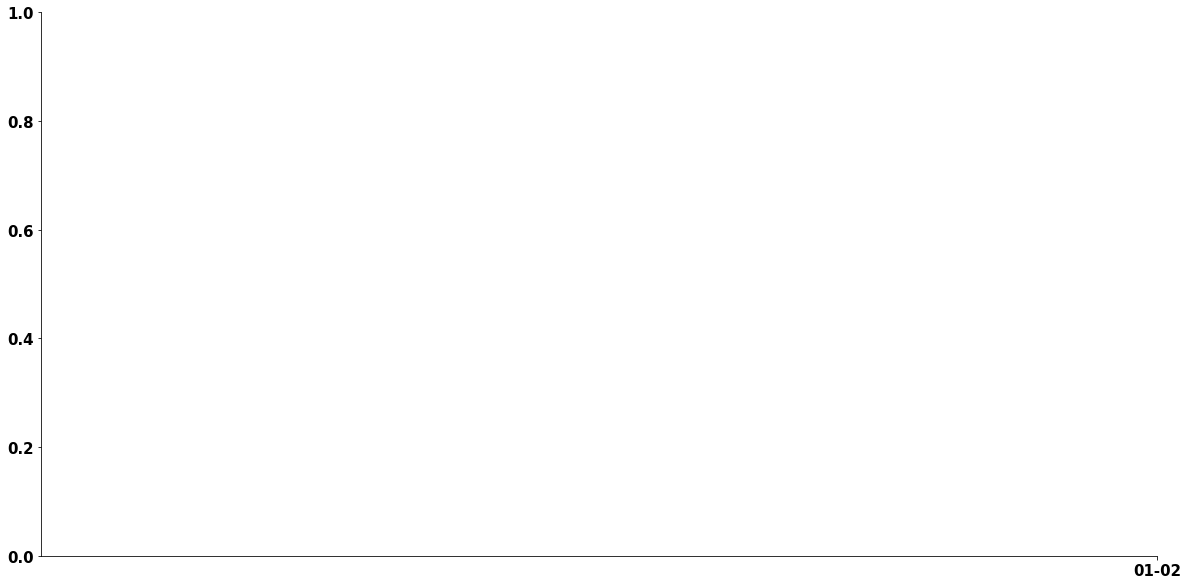

In [183]:




fig = plt.figure(figsize=(20,10))
ax = fig.gca()


ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)


march_2 = dt.date(2020,3,2)
then = march_2 + dt.timedelta(days=260)
t = mdates.drange(march_2,then,dt.timedelta(days=1))
t = t.astype('int32')

ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
ax.xaxis.set_major_locator(mdates.DayLocator([2]))








plt.plot(t[:259], casos_novos_diarios, color='blue', linewidth=7)

plt.plot(t[79:258], phas5b_novos, color='red', linewidth=7)

plt.fill_between(t[79:258], casos_novos_diarios[79:258], phas5b_novos, color='lightcyan', alpha='0.5')

#plt.plot(t[0:80], ativos, color='gray', marker = 'o', markersize=10)




font = {'family' : 'DejaVu Sans',
        'weight' : 'bold',
        'size'   : 25}

matplotlib.rc('font', **font)


from datetime import date

dates = [date.fromordinal(t[0]), date.fromordinal(t[63]),   date.fromordinal(t[91]), date.fromordinal(t[192])]

plt.xticks(dates, fontsize=15)
plt.yticks()

plt.ylabel('Número de novos casos')

plt.title('Evolução diária do número de novos casos diários confirmados ')

plt.show()

ValueError: x and y must have same first dimension, but have shapes (80,) and (92,)

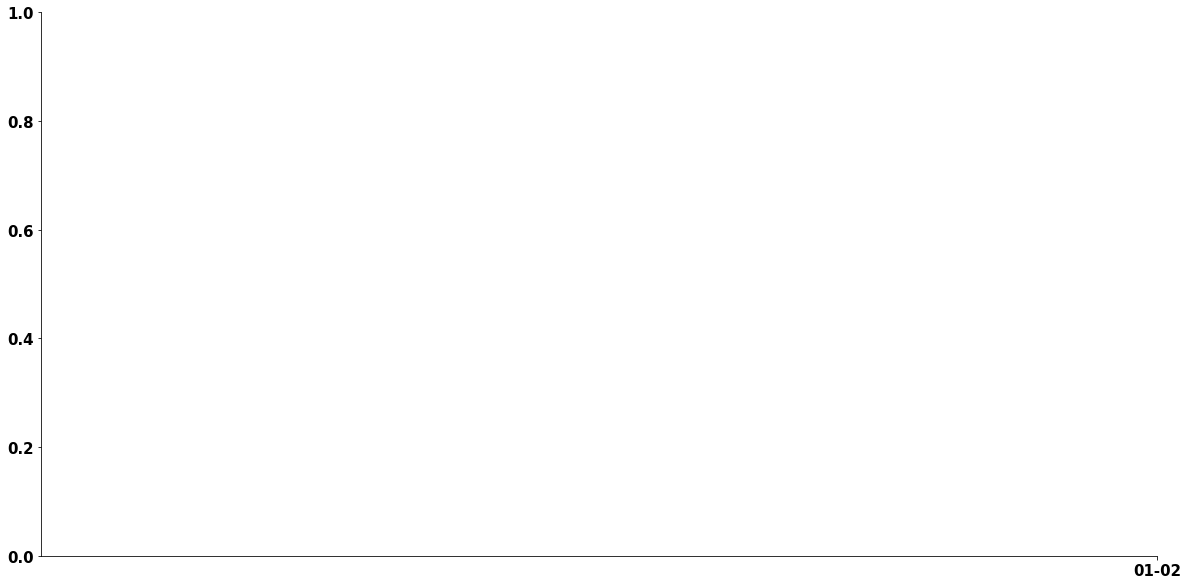

In [182]:

l= len(casos_novos)

aver = cma(casos_novos, 15)

fig = plt.figure(figsize=(20,10))
ax = fig.gca()

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

march_2 = dt.date(2020,3,2)
then = march_2 + dt.timedelta(days=260)
t = mdates.drange(march_2,then,dt.timedelta(days=1))
t = t.astype('int32')

ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
ax.xaxis.set_major_locator(mdates.DayLocator([2]))


plt.plot(t[0:80], aver,'b', linewidth=3.0)
plt.scatter(t[0:80], casos_novos, s=30, color='red', marker='o')


plt.ylabel('Número de casos')
plt.yticks([0, 250, 500, 750, 1000, 1250, 1500])


plt.title('Novos casos confirmados por dia')

plt.show()

In [43]:
ativos.dtype

dtype('int64')

In [44]:
casos_novos.dtype

dtype('int64')

In [45]:
max(aver)

794.5333333333333

In [46]:
hosp = pd.read_csv('TIME DATA PT.csv')

In [47]:
hosp.head(16)

,Date,Cases cumulative,New cases,Deaths cumulative,New deaths,Hospitalized cumulative CORRECTED,New hospitalized CORRECTED,New hospitalized (37% of hospitals),Hospitalized active,UCI,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19
0,3/2/20,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3/3/20,4.0,2.0,0.0,0.0,7.0,7.0,4.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3/4/20,5.0,1.0,0.0,0.0,15.0,8.0,5.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3/5/20,9.0,4.0,0.0,0.0,17.0,2.0,1.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3/6/20,13.0,4.0,0.0,0.0,19.0,2.0,1.0,13.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,3/7/20,21.0,8.0,0.0,0.0,29.0,10.0,6.0,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,3/8/20,30.0,9.0,0.0,0.0,32.0,3.0,2.0,30.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,3/9/20,39.0,9.0,0.0,0.0,34.0,2.0,1.0,38.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,3/10/20,41.0,2.0,0.0,0.0,39.0,5.0,3.0,40.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,3/11/20,59.0,18.0,0.0,0.0,46.0,7.0,4.0,57.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [48]:
internados = hosp['Hospitalized active']
#new_uci = hosp['New UCI']
new_cases = hosp['New cases']
internados_cum = hosp['Hospitalized cumulative CORRECTED']
uci = hosp['UCI']

In [49]:
len(internados)

85

In [50]:
new_uci[:20]

NameError: name 'new_uci' is not defined

In [51]:
prop_perc_new_uci_cases = (new_uci[5:45]/new_cases[0:40])*100

NameError: name 'new_uci' is not defined

In [52]:
print(prop_perc_new_uci_cases)
print(np.mean(prop_perc_new_uci_cases))

NameError: name 'prop_perc_new_uci_cases' is not defined

In [53]:
prop_perc_int_ati = (internados[16:80]/ativos[16:])*100

ValueError: operands could not be broadcast together with shapes (64,) (76,) 

In [ ]:
print(prop_perc_int_ati)
print(np.mean(prop_perc_int_ati))

In [138]:
prop_perc_uci_int = (uci[16:80]/internados[16:80])*100

In [139]:
print(prop_perc_uci_int)
print(np.mean(prop_perc_uci_int))

16    22.471910
17    22.471910
18    20.634921
19    22.435897
20    24.260355
        ...    
75    17.503805
76    16.640986
77    16.719745
78    16.057234
79    15.270936
Length: 64, dtype: float64
19.601144295068657


In [117]:
prop_perc_int_novos = (internados[27:80]/aver[27:])

In [118]:
print(prop_perc_int_novos)
print(np.mean(prop_perc_int_novos))

27    0.729146
28    0.845508
29    0.905895
30    1.010298
31    1.425965
32    1.331599
33    1.375971
34    1.424442
35    1.502461
36    1.603261
37    1.705954
38    1.661473
39    1.770625
40    1.798653
41    1.823487
42    1.857590
43    1.907452
44    1.886792
45    2.120061
46    2.178487
47    2.409924
48    2.422687
49    2.495524
50    2.439295
51    2.500000
52    2.488259
53    2.606573
54    2.529183
55    2.693407
56    2.806506
57    2.901426
58    3.060587
59    3.067822
60    2.722279
61    2.782599
62    2.979118
63    3.051802
64    3.016966
65    3.149587
66    3.281602
67    3.245952
68    3.197750
69    3.108424
70    3.074866
71    2.721341
72    2.622537
73    3.001698
74    3.284383
75    2.984856
76    2.973168
77    2.915506
78    3.024038
79    2.671053
Name: Hospitalized active, dtype: float64
2.3602988205050437


In [151]:
print(np.mean(uci[16:80]))
print(np.mean(ativos[16:80]))

156.0
15660.0


In [48]:
prop_perc_uci_novos = (uci[29:80]/ativos[29:80])*100

In [49]:
print(prop_perc_uci_novos)
print(np.mean(prop_perc_uci_novos))

29    2.596685
30    2.867473
31    2.740665
32    2.580443
33    2.464892
34    2.447745
35    2.393829
36    2.274826
37    1.949861
38    1.806326
39    1.526614
40    1.527769
41    1.442673
42    1.166108
43    1.318495
44    1.215734
45    1.292398
46    1.243976
47    1.239939
48    1.186315
49    1.101547
50    1.081218
51    1.032213
52    1.003344
53    0.907555
54    0.880932
55    0.848445
56    0.816289
57    0.788846
58    0.772360
59    0.775334
60    0.689563
61    0.666785
62    0.638581
63    0.628599
64    0.585536
65    0.590868
66    0.578109
67    0.535142
68    0.504605
69    0.468678
70    0.466939
71    0.476050
72    0.433228
73    0.451184
74    0.465406
75    0.483498
76    0.465879
77    0.487284
78    0.464282
79    0.423787
Name: UCI, dtype: float64
1.1332324221636922


In [104]:
np.mean(casos_novos[27:])

462.07547169811323

In [112]:
prop_perc_int_cum = (internados_cum[16:60]/casos_cum[16:60])*100

In [113]:
print(prop_perc_int_cum)
print(np.mean(prop_perc_int_cum))

16    22.741433
17    22.292994
18    20.490196
19    21.171875
20    20.375000
21    19.174757
22    19.263336
23    17.796327
24    18.289252
25    18.580131
26    18.046422
27    18.433412
28    19.413233
29    19.011151
30    19.052236
31    19.393403
32    19.360712
33    19.460281
34    19.444937
35    19.769821
36    19.675293
37    19.564721
38    19.224706
39    17.690021
40    17.795709
41    17.377148
42    17.272942
43    16.764099
44    16.168260
45    15.524654
46    15.376932
47    14.859030
48    14.475898
49    14.020035
50    13.681650
51    13.306342
52    13.085492
53    12.830636
54    12.569292
55    12.350631
56          NaN
57          NaN
58          NaN
59          NaN
Name: Hospitalized cumulative CORRECTED, dtype: float64
17.629360031060703
